In [2]:
import mne
mne.set_log_level('CRITICAL')
from pathlib import Path 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
import pandas as pd
import os

import seaborn as sns
sns.set_theme()

#import pickle

0.0%
0.03125%
0.0625%
0.09375%
0.125%
0.15625%
0.1875%
0.21875%
0.25%
0.28125%
0.3125%
0.34375%
0.375%
0.40625%
0.4375%
0.46875%
0.5%
0.53125%
0.5625%
0.59375%
0.625%
0.65625%
0.6875%
0.71875%
0.75%
0.78125%
0.8125%
0.84375%
0.875%
0.90625%
0.9375%
0.96875%


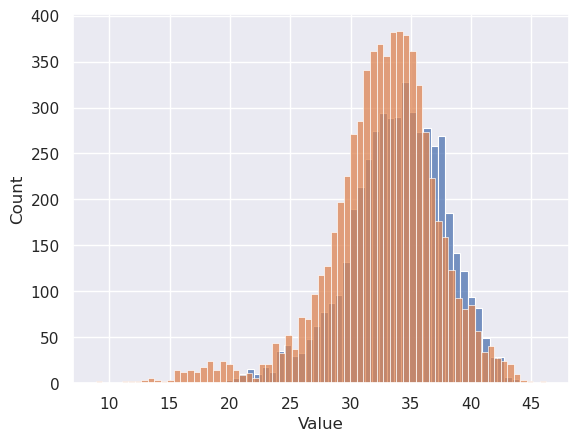

In [59]:
def getInput(file):    
    return mne.read_epochs(Path('out_data') / file )


# Train
#asd = getInput("2023/train_asd_concat_cleaned_1_40hz_epo.fif")
#td = getInput("2023/train_td_concat_cleaned_1_40hz_epo.fif")

# Test
asd = getInput("2023/test_asd_concat_cleaned_1_40hz_epo.fif")
td = getInput("2023/test_td_concat_cleaned_1_40hz_epo.fif")
dir = "test"


def getEpoch(psd, index):
    return psd[index]

def getBandPower(psd, epoch_id, channel_id, start, end, plot=False):
    if plot:
        plotSignal(psd[epoch_id][channel_id])
    return np.mean(psd[epoch_id][channel_id][start:end])

def plotSignal(y):
    _x = np.arange(len(y))
    sns.lineplot(x=_x, y=y)
    plt.show()

def scaleEEGPower(powerArray):
    powerArray = powerArray * 1e6**2 
    powerArray = (10 * np.log10(powerArray))
    return powerArray

def processChannel(epochs, channel_id, fmax=40, start=1, end=10, label=""):
    psd = epochs.compute_psd(fmax=fmax).get_data()
    psd = scaleEEGPower(psd)
    feature_array = []
    for epoch_id, epoch in enumerate(psd):
        pw = getBandPower(psd, epoch_id, channel_id, start, end)
        feature_array.append(pw)
    df = pd.DataFrame(feature_array, columns =['Value'], dtype = float) 
    #sns.histplot(data=df, x="Value")
    return feature_array, df.mean(), df.std()

def main():
    windowSizeMax = 3
    windowStartMax = 5
    df = pd.DataFrame([[1000, 1000, 1000, 1000]], columns =['channel', 'start', 'windowSize', 'diff'], dtype = float) 
    for windowIndex, windowStart in enumerate(range(windowStartMax)):
        for windowSize, window in enumerate(range(windowSizeMax)):
            _windowStart = windowStart +1
            _windowSize = window + 1
            _window_end = _windowStart + _windowSize
            print(f'{windowSize/windowSizeMax}%')
           
            #print(_windowStart, _window)
            for channel_id, channel in enumerate(asd.ch_names):
                #print(channel_id, channel)
                asd_y, asd_mean, std = processChannel(asd, channel_id, start=_windowStart, end=_window_end, label="ASD")
                td_y, td_mean, std  = processChannel(td, channel_id, start=_windowStart, end=_window_end, label="TD")
                _diff = abs((asd_mean-td_mean).get("Value"))
                _title = f'channel: {channel}; _windowStart: {_windowStart}; _window_end: {_window_end}; ASD Mean: {asd_mean}; TD Mean: {td_mean}; DIFF: {_diff}'
                new_row = {'channel':channel, 'start':_windowStart, 'windowSize':_windowSize, 'diff':_diff}
                df = pd.concat([df, pd.DataFrame.from_records([new_row])])
                #sns.histplot().set(title=_title)
                #plt.figure()
    print(df.head())
    os.makedirs('out_data', exist_ok=True)
    file_name = f'out_data/{dir}_windowSizeMax_{windowSizeMax}_windowStartMax_{windowStartMax}.csv'
    df.to_csv(file_name) 
#main()

def getChannelIndex(epochs, channel_name):
    return epochs.ch_names.index(channel_name)

def eval(band_start, band_size):
    _end = band_start + band_size
    df = pd.DataFrame([[1000, 1000, 1000, 1000, 1000, 1000]], columns =['channel', 'start', 'windowSize', 'diff', 'asd_std_', 'td_std_'], dtype = float) 
    all_asd_y = []
    all_td_y = []
    for channel_id, channel in enumerate(asd.ch_names):
        print(f'{channel_id/len(asd.ch_names)}%')
        asd_y, asd_mean, asd_std = processChannel(asd, channel_id, start=band_start, end=_end, label="ASD")
        td_y, td_mean, td_std  = processChannel(td, channel_id, start=band_start, end=_end, label="TD")
        _diff = abs((asd_mean-td_mean).get("Value"))
        #_title = f'channel: {channel}; ASD Mean: {asd_mean}; TD Mean: {td_mean}; DIFF: {_diff}'
        asd_df = pd.DataFrame(asd_y, columns =['Value'], dtype = float) 
        asd_std = asd_std.get("Value")
        td_std = td_std.get("Value")
        new_row = {'channel':channel, 'start':band_start, 'windowSize':band_size, 'diff':_diff, 'asd_std_': asd_std, 'td_std_': td_std }
        df = pd.concat([df, pd.DataFrame.from_records([new_row])])
        all_asd_y += asd_y
        all_td_y += td_y
    #print(f'all_asd_y len: {len(all_asd_y)}, all_td_y len: {len(all_td_y)}')

    asd_df = pd.DataFrame(all_asd_y, columns =['Value'], dtype = float) 
    sns.histplot(data=asd_df, x="Value")


    td_df = pd.DataFrame(all_td_y, columns =['Value'], dtype = float) 
    sns.histplot(data=td_df, x="Value")
    plt.show()

    file_name = f'out_data/{dir}_start_{band_start}_end_{_end}.csv'
    df.to_csv(file_name)

def evalSingleChannel(band_start, window_size, channel_id):
    _end = band_start + window_size
    channel_index = getChannelIndex(asd, channel_id)
    asd_y, asd_mean, std = processChannel(asd, channel_index, start=band_start, end=_end, label="ASD")
    td_y, td_mean, std  = processChannel(td, channel_index, start=band_start, end=_end, label="TD")

    asd_df = pd.DataFrame(asd_y, columns =['Value'], dtype = float) 
    sns.histplot(data=asd_df, x="Value")

    td_df = pd.DataFrame(td_y, columns =['Value'], dtype = float) 
    sns.histplot(data=td_df, x="Value")

    _title = f'channel: {channel_id}; ASD Mean: {asd_mean}; TD Mean: {td_mean}; DIFF: {abs(asd_mean-td_mean)}'
    sns.histplot().set(title=_title)
    plt.show()

#evalSingleChannel(10, 4, 'Oz')
#evalSingleChannel(8, 4, 'Pz')
#evalSingleChannel(8, 4, 'P3')

eval(10, 4)
#eval(1, 3)





### UTIL ####

def plotRange(psd):
    for epoch_id, epoch in enumerate(psd):
        for channel_id, channel in enumerate(epoch):
            print(channel_id)
            plotSignal(channel)


    #channel_ids = np.array([np.full((asd.get_data().shape[1]), channel_name) for channel_name in asd.ch_names]).reshape(1, -1).squeeze()
    #print(channel_ids)